In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cartopy.crs as ccrs

In [19]:
import torch
import torch.nn
import torch.nn.functional as F

In [66]:
import scipy.ndimage.filters

In [78]:
import scipy.signal

In [34]:
import PIL.Image

In [35]:
def make_image(x):
    scaled = (np.nan_to_num(x).clip(200,296)-200)/(296-200)*255
    return PIL.Image.fromarray(255 - scaled.astype(np.uint8))

In [173]:
def resize(im, size=(512,512)):
    return im.resize(size, resample=PIL.Image.NEAREST)

In [3]:
from tqdm import tqdm

In [4]:
%cd ..

/ships19/cloud/scratch/cphillips/isccp_l1g


In [5]:
import sys 
sys.path.append('/ships19/cloud/scratch/cphillips/utility')
from make_gif import make_video, render_fast, play_video

In [6]:
import xarray as xr

In [7]:
from pathlib import Path

In [8]:
import make_sample

(3, 3600, 7200)


In [9]:
AHI_PROJ = ccrs.Geostationary(140.7)

In [10]:
files = list(Path('l1b/2020/202007/20200701/20200701T0000/h8/temp_10_40um/').glob('*'))

In [11]:
scene, area = make_sample.read_scene(files, None)

In [12]:
search = scene[2000:2512,2000:2512].load().values

In [656]:
tile = scene[2256:2512,2512:2512+256].load().values
search=tile

In [657]:
tile = tile[:64,:64]
search = tile

In [658]:
# tile = tile[::2,::2]
# search = tile

In [659]:
#tile[:] = 295
#x,y = np.meshgrid(np.arange(tile.shape[0]), np.arange(tile.shape[1]))

In [660]:
#tile[(((x/10) % 1 - .5)**2 + ((y/10) % 1 - .5)**2) < .05] = 250

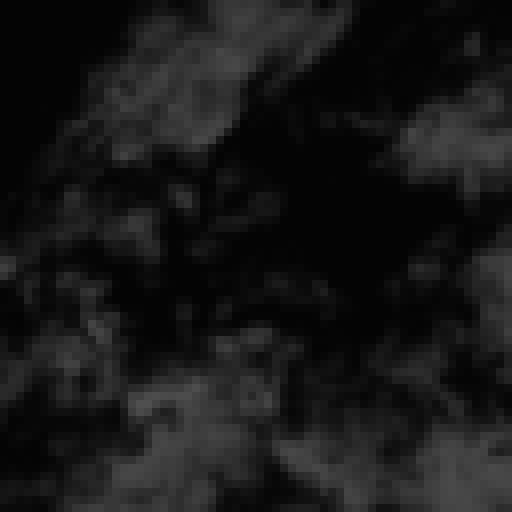

In [661]:
resize(make_image(tile))

In [725]:
s = 1
template_size = 8
canvas = np.full((64*s,64*s), np.nan, dtype=np.float64)

np.random.seed(0)
# Fill first 2 lines and first 2 columns of 3rd
seed = tile.ravel()[np.random.randint(0, tile.size-1, canvas.shape[1]*(template_size-1))]
canvas.ravel()[:len(seed)] = seed
seed = tile.ravel()[np.random.randint(0, tile.size-1, canvas.shape[0]*(template_size-1))]
canvas[:,:template_size-1] = seed.reshape((-1,template_size-1))
# canvas[:,:template_size-1] = 295
# canvas[:template_size-1] = 295
canvas[:,:template_size-1] = tile[:,:template_size-1]
canvas[:template_size-1] = tile[:template_size-1]

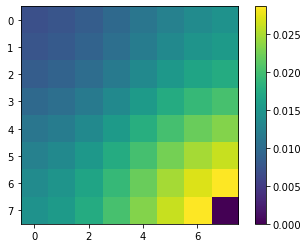

In [728]:
weights = np.zeros((template_size*2+1,template_size*2+1))
weights[template_size,template_size] = 1
weights = scipy.ndimage.filters.gaussian_filter(weights, 5)[:template_size,:template_size]
weights[template_size-1,template_size-1] = 0
weights /= weights.sum()
imshow(weights)
colorbar()

In [729]:
tile_view = np.lib.stride_tricks.sliding_window_view(tile, (template_size,template_size))

In [730]:
topk = 5
with tqdm(range(template_size-1, canvas.shape[0])) as bar:
    for i in bar:
        for j in range(template_size-1, canvas.shape[1]):
            template = canvas[i-template_size+1:i+1,j-template_size+1:j+1]
            sqr_err = ((tile_view - np.nan_to_num(template[np.newaxis,np.newaxis]))**2)
            mean_sqr_err = (sqr_err*weights).sum(axis=(2,3))
            best_i, best_j = np.unravel_index(np.argpartition(mean_sqr_err.ravel(), topk)[:topk], mean_sqr_err.shape)
            #best_i, best_j = np.unravel_index(mean_sqr_err.argmin(), mean_sqr_err.shape)
            choice = np.random.randint(0,topk)
            best_i = best_i[choice]
            best_j = best_j[choice]
            s = tile[best_i:best_i+template_size, best_j:best_j+template_size]
            canvas[i,j] = s[-1,-1]
#             break
#         break

100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


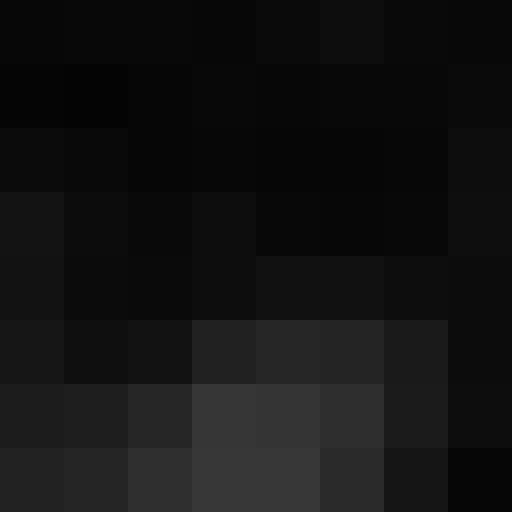

In [731]:
resize(make_image(s))

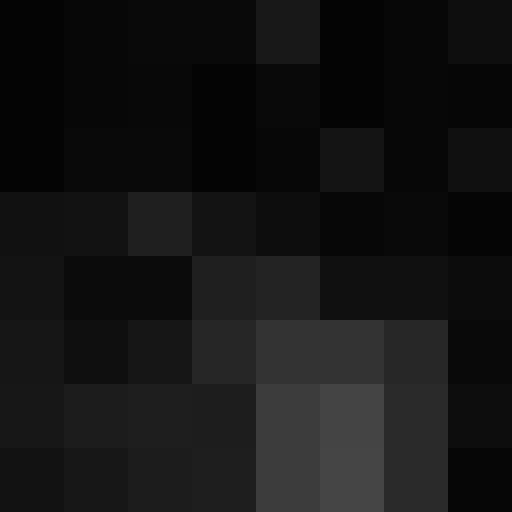

In [732]:
resize(make_image(template))

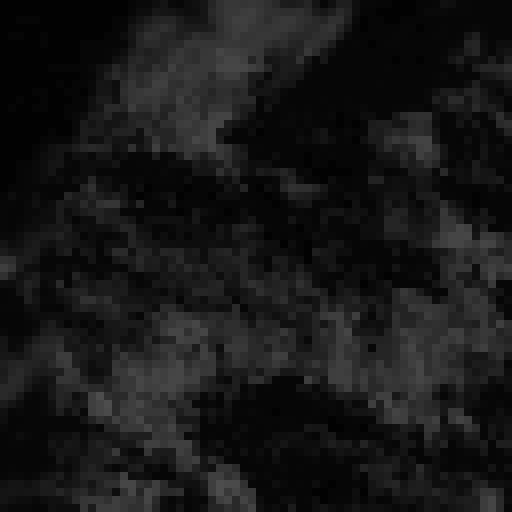

In [733]:
resize(make_image(canvas[:,:]))

In [734]:
tile.shape

(64, 64)

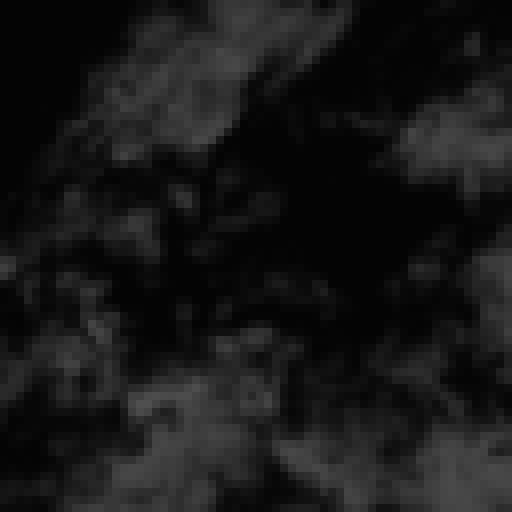

In [735]:
resize(make_image(tile))